Plotting the intitial wavefunction ($\psi(x)$'s) Wigner function

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from scipy.fftpack import fft,ifft
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [2]:
#first we define a function to give us one part of the initial wave function (psi(x+y))
def gauss_x_plus(x, y, a, x0, k0):
  array = np.zeros((len(x),len(x)), dtype=complex)
  for i in range(len(y)):
    array[i][:] = (a * np.sqrt(np.pi)) ** (-0.5) * np.exp(-0.5 * (((x+y[i]) - x0 ) * 1. / a) ** 2 + 1j * (x+y[i])* k0)
  return array

#and the other part of the initial wave fucntion (psi*(x-y))
def gauss_x_minus(x, y, a, x0, k0):
  array = np.zeros((len(x),len(x)), dtype=complex)
  for i in range(len(y)):
    array[i][:] = np.conjugate((a * np.sqrt(np.pi)) ** (-0.5) * np.exp(-0.5 * (((x-y[i]) - x0) * 1. / a) ** 2 + 1j * (x-y[i]) * k0))
  return array

In [3]:
#setting values of variables
#ive commented out the unnecessary ones for this plot

# dt = 0.01
# N_steps = 50
# t_max = 120
# frames = int(t_max / float(N_steps * dt))
hbar = 1.0 
m = 1.0 #mass


N = 2 ** 11
dx = 0.1
x = dx * (np.arange(N) - 0.5 * N)
dy = 0.1
y = dy * (np.arange(N) - 0.5 * N)
#the x and y grid needs to match up

V0 = 1.0
L = hbar / np.sqrt(2 * m * V0)
a = 3 * L
x0 = -60 * L
#V_x = square_barrier(x, a, V0)
# V_x = np.e**((-x**2)/1) 
# V_x[x < -98] = 1E6
# V_x[x > 98] = 1E6
p0 = np.sqrt(2 * m * 0.8 * V0)
# dp2 = p0 * p0 * 1./80
# d = hbar / np.sqrt(2 * dp2)
d = 2
k0 = p0 / hbar
v0 = p0 / m

k0_ft = -np.pi / dy
#value in the discrete version of wave

In [4]:
psi_x0_plus = gauss_x_plus(x, y, d, x0, k0)
psi_x0_minus = gauss_x_minus(x, y, d, x0, k0)
#getting our two initial wave functions with specified values

In [5]:
#multiplying the two wavefunction together so our function is of the form psi(x+y)psi*(x-y)
wigner_to_transform = np.multiply(psi_x0_plus,psi_x0_minus)

#discretising the function so we can fourier transform correctly
discrete_wigner_to_tranform = np.zeros((len(y),len(x)), dtype = complex)
for i in range(len(y)):
  discrete_wigner_to_tranform[i][:] = wigner_to_transform[i] * np.exp(-1j * k0_ft * y[i]) * dy / np.sqrt(2 * np.pi)

#fast fourier transforming
discrete_fourier_wigner = fft(discrete_wigner_to_tranform, axis = 0)

#un-discretising the function
wigner = np.zeros((len(y),len(x)), dtype = complex)
for i in range(len(y)):
  wigner[i][:] = (discrete_fourier_wigner[i] * np.exp(1j * k0_ft * y[i]) * np.sqrt(2 * np.pi) / dy)

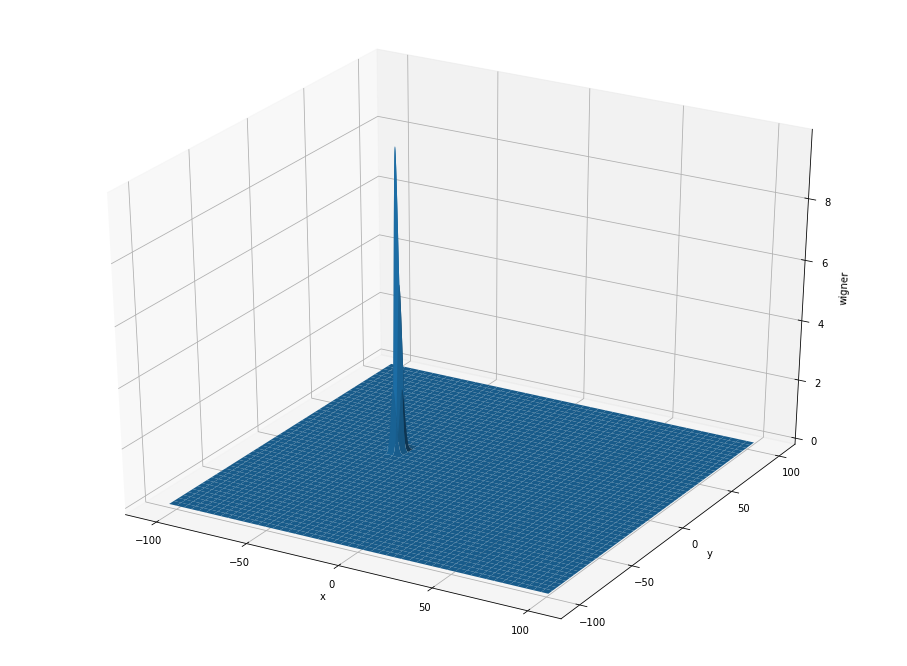

In [6]:
#plotting the wigner function
fig = plt.figure(figsize=(16,12))

ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(x, y)
Z = np.real(wigner)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('wigner')

ax.plot_surface(X,Y,Z)
#ax.view_init(azim = 170)